Sentiment Analysis: Creating DataFrame from Files

In [2]:
import pandas as pd
from transformers import AutoTokenizer
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
import string

from transformers import AutoModelForSequenceClassification
import torch
import scipy
from scipy.special import softmax
import typing
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import nltk
#nltk.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
import gc
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

from textblob import TextBlob
import re

pattern = r"Q\d+ \d{4}"
date_pattern = r'(?:Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)\s+\d{1,2},\s+\d{4}'
pattern_ticker = r"\((.*?)\)"
quarter_to_month = {4: (1, 3), 1: (4, 6), 2: (7, 9), 3: (10, 12)}



def def_value(): 
    return "Not Present"


zip_file_path = "C://Users//egare//Downloads//Trancripts-20240224T224531Z-001.zip"

        



c:\Users\egare\anaconda3\envs\new_era\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Word Matching to Separate Q&A from Formal Report

Alternative

In [3]:



company_alt_data = []

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    for file_info in zip_ref.infolist():
        parts = file_info.filename.split('/')
        
        # Extract company name, date, and ticker
        company_name = parts[1]
        extract_date = re.search(pattern, parts[2])
        extract_ticker = re.search(pattern_ticker, parts[2])
        
        if extract_date and extract_ticker:
            date = extract_date.group()
            ticker = extract_ticker.group(1)
            
            if '(' in company_name:
                company_name = company_name.split('(')[0].strip()  # Remove ticker from company name
            
            with zip_ref.open(file_info) as file:
                text = file.read().decode('utf-8')
                match_date = re.search(date_pattern, text)
                if match_date:
                    new_date = match_date.group()
                
                # Append data to company_data list
                company_alt_data.append({
                    "name": company_name,
                    "ticker": ticker,
                    "date": date,
                    "text": text,
                    "new_date": new_date
                })
                

# Create DataFrame from company_data
df_alt = pd.DataFrame(company_alt_data)
df_alt = df_alt.rename_axis("transcript_id")


In [11]:
df_alt.shape
df_alt['text'] = df_alt['text'].str.replace('Image source: The Motley Fool.\n', '')


In [12]:
df_alt

,name,ticker,date,text,new_date,Report,Q&A
transcript_id,,,,,,,
0,Constellation Energy Corporation,CEG,Q2 2022,\nConstellation Energy Corporation (CEG 0.45%)...,"Aug 04, 2022",Image source: The Motley Fool. Constellation E...,"Steve Fleishman, and Steve is with Wolfe Resea..."
1,"United Rentals, Inc.",URI,Q2 2020,\nUnited Rentals Inc (URI -0.09%)Q2 2020 Earni...,"Jul 30, 2020",Image source: The Motley Fool. United Rentals ...,Raso from Evercore ISI. Your question please. ...
2,"United Rentals, Inc.",URI,Q4 2019,\nUnited Rentals Inc (URI -0.09%)Q4 2019 Earni...,"Jan 30, 2020",Image source: The Motley Fool. United Rentals ...,line of David Raso from Evercore ISI. Your que...
3,"United Rentals, Inc.",URI,Q1 2019,\nUnited Rentals Inc (URI -0.09%)Q1 2019 Earn...,"Jan 30, 2020",Image source: The Motley Fool. United Rentals ...,Gilardi from Bank of America Merrill Lynch. Yo...
4,"United Rentals, Inc.",URI,Q4 2018,\nUnited Rentals Inc (URI -0.09%)Q4 2018 Earn...,"Jan 30, 2020",Image source: The Motley Fool. United Rentals ...,the line of Ross Gilardi from Bank of America ...
...,...,...,...,...,...,...,...
3357,"T-Mobile Us, Inc.",TMUS,Q2 2022,\nT-Mobile US (TMUS 0.69%)Q2 2022 Earnings Cal...,"Jul 27, 2022",Image source: The Motley Fool. T-Mobile US (TM...,"to Mr. Jud Henry, senior vice president and he..."
3358,"Equinix, Inc. Reit",EQIX,Q4 2023,\nEquinix (EQIX 0.10%)Q4 2023 Earnings CallFeb...,"Feb 14, 2024",Image source: The Motley Fool. Equinix (EQIX 0...,Your line is open. Simon Flannery -- Morgan St...
3359,"T-Mobile Us, Inc.",TMUS,Q2 2023,\nT-Mobile US (TMUS 0.69%)Q2 2023 Earnings Cal...,"Jul 27, 2023",Image source: The Motley Fool. T-Mobile US (TM...,us or what's going on. And it's kind of intere...


In [13]:
def split_text_into_chunks(text, chunk_size):
    words = text.split() 
    chunks = [words[i:i+chunk_size] for i in range(0, len(words), chunk_size)] 
    return [' '.join(chunk) for chunk in chunks] 

def split_text_at_match(text_chunks, match):
    try:
        index = text_chunks.index(match)
        first_half_chunks = text_chunks[:index]
        second_half_chunks = text_chunks[index+1:]
        first_half = ' '.join(first_half_chunks)
        second_half = ' '.join(second_half_chunks)
        return first_half, second_half
    except ValueError:
        return ''.join(text_chunks), ""

In [14]:
def qa_recap_splitter(data):
    report_texts = []
    qa_texts = []
    for transcript in data['text']:
        trans_split = split_text_into_chunks(transcript, 14)
        matcher = process.extract("[Operator Instructions] Our first question comes from]", trans_split, scorer=fuzz.ratio, limit=1)
        first_half, second_half = split_text_at_match(trans_split, matcher[0][0] )
        report_texts.append(first_half.strip())  # Remove leading/trailing spaces
        qa_texts.append(second_half.strip())  # Rem
    data['Report'] = report_texts
    data["Q&A"] = qa_texts
text_breaker = split_text_into_chunks(df_alt['text'][200], 14)
matcher = process.extract("[Operator Instructions] Our first question comes from]", text_breaker, scorer=fuzz.ratio, limit=1)
print(matcher)
split_text_at_match(text_breaker, matcher[0][0])
qa_recap_splitter(df_alt)



[('[Operator Instructions] Your next question is from Adrienne Yih from Barclays. Your line is', 65)]


In [15]:
df_alt

,name,ticker,date,text,new_date,Report,Q&A
transcript_id,,,,,,,
0,Constellation Energy Corporation,CEG,Q2 2022,\nConstellation Energy Corporation (CEG 0.45%)...,"Aug 04, 2022",Constellation Energy Corporation (CEG 0.45%)Q2...,would now like to introduce your host for toda...
1,"United Rentals, Inc.",URI,Q2 2020,\nUnited Rentals Inc (URI -0.09%)Q2 2020 Earni...,"Jul 30, 2020",United Rentals Inc (URI -0.09%)Q2 2020 Earning...,Gilardi from Bank of America. Your question pl...
2,"United Rentals, Inc.",URI,Q4 2019,\nUnited Rentals Inc (URI -0.09%)Q4 2019 Earni...,"Jan 30, 2020",United Rentals Inc (URI -0.09%)Q4 2019 Earning...,Evercore ISI. Your question please. David Raso...
3,"United Rentals, Inc.",URI,Q1 2019,\nUnited Rentals Inc (URI -0.09%)Q1 2019 Earn...,"Jan 30, 2020",United Rentals Inc (URI -0.09%)Q1 2019 Earning...,of David Raso from Evercore ISI. Your question...
4,"United Rentals, Inc.",URI,Q4 2018,\nUnited Rentals Inc (URI -0.09%)Q4 2018 Earn...,"Jan 30, 2020",United Rentals Inc (URI -0.09%)Q4 2018 Earning...,from Bank of America Merrill Lynch. Your quest...
...,...,...,...,...,...,...,...
3357,"T-Mobile Us, Inc.",TMUS,Q2 2022,\nT-Mobile US (TMUS 0.69%)Q2 2022 Earnings Cal...,"Jul 27, 2022",T-Mobile US (TMUS 0.69%)Q2 2022 Earnings CallJ...,"Operator, first question, please. Operator We'..."
3358,"Equinix, Inc. Reit",EQIX,Q4 2023,\nEquinix (EQIX 0.10%)Q4 2023 Earnings CallFeb...,"Feb 14, 2024",Equinix (EQIX 0.10%)Q4 2023 Earnings CallFeb 1...,Simon Flannery with Morgan Stanley. You may go...
3359,"T-Mobile Us, Inc.",TMUS,Q2 2023,\nT-Mobile US (TMUS 0.69%)Q2 2023 Earnings Cal...,"Jul 27, 2023",T-Mobile US (TMUS 0.69%)Q2 2023 Earnings CallJ...,"Jud Henry, senior vice president and head of i..."


In [80]:
filtered_row = df_alt[(df_alt['ticker'] == 'AAPL') & (df_alt['adjusted_date'] == '2019-10-30')]

# Check if any rows match the condition
if not filtered_row.empty:
    # Print the "Report" value from the first row (assuming there's only one matching row)
    present_text = filtered_row['Report'].iloc[0]
    present_qa = filtered_row['Q&A'].iloc[0]
    print(filtered_row['Report'].iloc[0])
else:
    print("No matching row found for ticker 'AAPL' and adjusted_date '2019-10-30'")
    
present_chunks = split_text_into_chunks(present_text, 30)
present_chunks_qa = split_text_into_chunks(present_qa, 30)

def calculate_sentiment_chunks(chunks):
    sentiment_dict = {}
    for i, chunk in enumerate(chunks):
        blob = TextBlob(chunk)
        polarity = blob.sentiment.polarity
        subjectivity = blob.sentiment.subjectivity
        sentiment_dict[f'Chunk {i+1}'] = {'Text': chunk, 'Polarity': polarity}
    return sentiment_dict

# Function to split text into chunks


sentiment_dict = calculate_sentiment_chunks(present_chunks)

# Print the sentiment scores for each chunk
for chunk, info in sentiment_dict.items():
    print(f"Chunk {chunk}:")
    print(f"Text: {info['Text']}")
    print(f"Polarity: {info['Polarity']}")
    print()
    
sentiment_dict_qa = calculate_sentiment_chunks(present_chunks_qa)
for chunk, info in sentiment_dict_qa.items():
    print(f"Chunk {chunk}:")
    print(f"Text: {info['Text']}")
    print(f"Polarity: {info['Polarity']}")
    print()

Apple Inc. (AAPL 1.32%)Q4 2019 Earnings CallOct 30, 2019, 5:00 p.m. ET Operator Good day, everyone. Welcome to the Apple Incorporated Fourth Quarter Fiscal Year 2019 Earnings Conference Call. [Operator Instructions] At this time for opening remarks and introductions, I would like to turn the call over to Nancy Paxton, Senior Director of Investor Relations. Please go ahead. Nancy Paxton -- Senior Director, Investor Relations Thank you. Good afternoon, and thanks to everyone for joining us. Speaking first today is Apple's CEO, Tim Cook, and he'll be followed by CFO, Luca Maestri. And after that, we'll open the call to questions from analysts. Please note that some of the information you'll hear during our discussion today will consist of forward-looking statements, including without limitation, those regarding revenue, gross margin, operating expenses, other income and expense, taxes, capital allocation and future business outlook. Actual results or trends could differ materially from ou

TetBLOB SENTIMENT INDEX

In [17]:
def get_sentiment(text):
    test = TextBlob(text)
    return test.sentiment.polarity


df_alt['sentiment_index_report'] = df_alt['Report'].apply(get_sentiment)
df_alt['sentiment_index_Q&A'] = df_alt['Q&A'].apply(get_sentiment)



In [72]:
filtered_row_tester = df_sorted[(df_sorted['ticker'] == 'AAPL')]
filtered_row_tester
#(df_sorted['adjusted_date'] == '2021-06-30')

KeyError: 6

FINBERT

In [ ]:
"""
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model_finbert = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")

encoded = tokenizer(df_alt['text'][1], max_length=512, padding="max_length", truncation=True, return_tensors='pt')
output = model_finbert(**encoded)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
"""

In [18]:

df_alt['adjusted_date'] = pd.to_datetime(df_alt['new_date'])
df_alt = df_alt.drop('new_date', axis=1)

In [19]:
df_alt

,name,ticker,date,text,Report,Q&A,sentiment_index_report,sentiment_index_Q&A,adjusted_date
transcript_id,,,,,,,,,
0,Constellation Energy Corporation,CEG,Q2 2022,\nConstellation Energy Corporation (CEG 0.45%)...,Constellation Energy Corporation (CEG 0.45%)Q2...,would now like to introduce your host for toda...,0.500000,0.192438,2022-08-04
1,"United Rentals, Inc.",URI,Q2 2020,\nUnited Rentals Inc (URI -0.09%)Q2 2020 Earni...,United Rentals Inc (URI -0.09%)Q2 2020 Earning...,Gilardi from Bank of America. Your question pl...,0.148872,0.142176,2020-07-30
2,"United Rentals, Inc.",URI,Q4 2019,\nUnited Rentals Inc (URI -0.09%)Q4 2019 Earni...,United Rentals Inc (URI -0.09%)Q4 2019 Earning...,Evercore ISI. Your question please. David Raso...,0.104884,0.151459,2020-01-30
3,"United Rentals, Inc.",URI,Q1 2019,\nUnited Rentals Inc (URI -0.09%)Q1 2019 Earn...,United Rentals Inc (URI -0.09%)Q1 2019 Earning...,of David Raso from Evercore ISI. Your question...,0.190080,0.196082,2020-01-30
4,"United Rentals, Inc.",URI,Q4 2018,\nUnited Rentals Inc (URI -0.09%)Q4 2018 Earn...,United Rentals Inc (URI -0.09%)Q4 2018 Earning...,from Bank of America Merrill Lynch. Your quest...,0.180050,0.177323,2020-01-30
...,...,...,...,...,...,...,...,...,...
3357,"T-Mobile Us, Inc.",TMUS,Q2 2022,\nT-Mobile US (TMUS 0.69%)Q2 2022 Earnings Cal...,T-Mobile US (TMUS 0.69%)Q2 2022 Earnings CallJ...,"Operator, first question, please. Operator We'...",0.215404,0.180442,2022-07-27
3358,"Equinix, Inc. Reit",EQIX,Q4 2023,\nEquinix (EQIX 0.10%)Q4 2023 Earnings CallFeb...,Equinix (EQIX 0.10%)Q4 2023 Earnings CallFeb 1...,Simon Flannery with Morgan Stanley. You may go...,0.141842,0.147419,2024-02-14
3359,"T-Mobile Us, Inc.",TMUS,Q2 2023,\nT-Mobile US (TMUS 0.69%)Q2 2023 Earnings Cal...,T-Mobile US (TMUS 0.69%)Q2 2023 Earnings CallJ...,"Jud Henry, senior vice president and head of i...",0.700000,0.195710,2023-07-27


In [50]:
df_alt['word_count'] = df_alt['Report'].str.split().str.len()

# Filter out rows with less than 50 words in the "Report" column
df_alt = df_alt[df_alt['word_count'] >= 50]



# Drop the "word_count" column
df_alt = df_alt.drop(columns=['word_count'])

df_alt['word_count_q_a'] = df_alt['Q&A'].str.split().str.len()

# Filter out rows with less than 50 words in the "Report" column
df_alt = df_alt[df_alt['word_count_q_a'] >= 50]

df_alt = df_alt.drop(columns=['word_count_q_a'])


In [51]:
df_alt.shape

(3260, 8)

remove old Q Year Format

In [27]:
df_alt = df_alt.drop(columns=['date'])
df_alt

,name,ticker,text,Report,Q&A,sentiment_index_report,sentiment_index_Q&A,adjusted_date
transcript_id,,,,,,,,
1,"United Rentals, Inc.",URI,\nUnited Rentals Inc (URI -0.09%)Q2 2020 Earni...,United Rentals Inc (URI -0.09%)Q2 2020 Earning...,Gilardi from Bank of America. Your question pl...,0.148872,0.142176,2020-07-30
2,"United Rentals, Inc.",URI,\nUnited Rentals Inc (URI -0.09%)Q4 2019 Earni...,United Rentals Inc (URI -0.09%)Q4 2019 Earning...,Evercore ISI. Your question please. David Raso...,0.104884,0.151459,2020-01-30
3,"United Rentals, Inc.",URI,\nUnited Rentals Inc (URI -0.09%)Q1 2019 Earn...,United Rentals Inc (URI -0.09%)Q1 2019 Earning...,of David Raso from Evercore ISI. Your question...,0.190080,0.196082,2020-01-30
4,"United Rentals, Inc.",URI,\nUnited Rentals Inc (URI -0.09%)Q4 2018 Earn...,United Rentals Inc (URI -0.09%)Q4 2018 Earning...,from Bank of America Merrill Lynch. Your quest...,0.180050,0.177323,2020-01-30
5,"United Rentals, Inc.",URI,\nUnited Rentals Inc (URI -0.09%)Q2 2019 Earni...,United Rentals Inc (URI -0.09%)Q2 2019 Earning...,from Evercore ISI. Your question please. David...,0.145248,0.158427,2019-07-18
...,...,...,...,...,...,...,...,...
3356,"T-Mobile Us, Inc.",TMUS,\nT-Mobile US (TMUS 0.69%)Q2 2020 Earnings Cal...,T-Mobile US (TMUS 0.69%)Q2 2020 Earnings CallA...,open. Phil Cusick -- J.P. Morgan -- Analyst He...,0.153952,0.151800,2020-08-06
3357,"T-Mobile Us, Inc.",TMUS,\nT-Mobile US (TMUS 0.69%)Q2 2022 Earnings Cal...,T-Mobile US (TMUS 0.69%)Q2 2022 Earnings CallJ...,"Operator, first question, please. Operator We'...",0.215404,0.180442,2022-07-27
3358,"Equinix, Inc. Reit",EQIX,\nEquinix (EQIX 0.10%)Q4 2023 Earnings CallFeb...,Equinix (EQIX 0.10%)Q4 2023 Earnings CallFeb 1...,Simon Flannery with Morgan Stanley. You may go...,0.141842,0.147419,2024-02-14


ROBERTA - Model

In [ ]:

"""
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)
"""

In [ ]:
def filter_by_quarter_year(q: int, y: int, data: pd.DataFrame):
    result = data[(data['adjusted_date'].dt.month >= quarter_to_month[q][0]) & (data['adjusted_date'].dt.month <= quarter_to_month[q][1]) & (data['adjusted_date'].dt.year == y)]
    return result
    

filtered_rows = df_alt[(df_alt['ticker'] == 'AMZN')]
q_y_interest = filter_by_quarter_year(1, 2022, filtered_rows)


# Print only the values under the 'text' column
print(q_y_interest['text'].values, "\n", q_y_interest['sentiment_index'].values)

KeyError: 'sentiment_index'

<Figure size 1000x600 with 0 Axes>

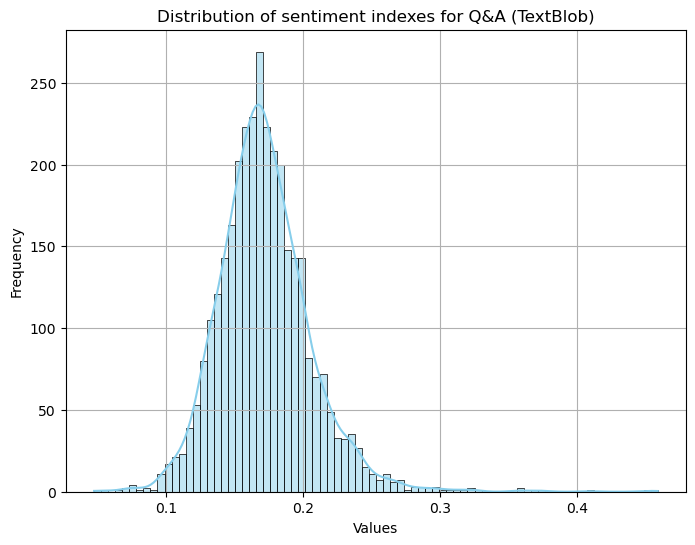

In [30]:
variance = df_alt['sentiment_index_Q&A'].var()
plt.figure(figsize=(8, 6))
sns.histplot(df_alt['sentiment_index_Q&A'], kde=True, color='skyblue')
plt.title('Distribution of sentiment indexes for Q&A (TextBlob)')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


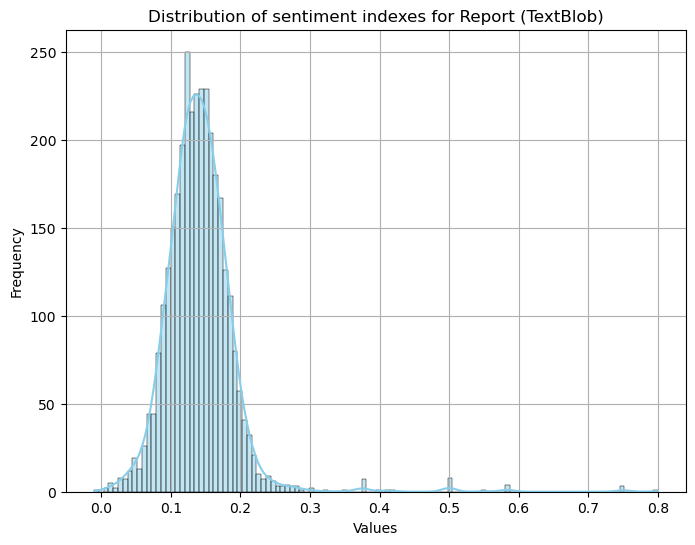

In [31]:
variance = df_alt['sentiment_index_report'].var()
plt.figure(figsize=(8, 6))
sns.histplot(df_alt['sentiment_index_report'], kde=True, color='skyblue')
plt.title('Distribution of sentiment indexes for Report (TextBlob)')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

Export DF to EXCEL

In [ ]:
#df_alt.to_excel("sentiment_trans_03-04.xlsx")

Aggregate

In [35]:
df_total = pd.read_csv('C:/Users/egare/Downloads/sentiment_output.csv')




In [36]:
df_total

,sentiment1,sentiment2,ret_1_0,seas_1_1an,market_equity,ret_2_0,ret_3_0,ret_3_1,assets,sales,...,market_equity.1,yom,transcript_id,name,ticker,text,new_date,adjusted_date,text_blob_sentiment_index,VADER_sentiment_index
0,0.169172,0.145,0.125889,0.086473,1.900416e+05,0.029640,0.065297,-0.053817,109438.0,39383.0,...,1.900416e+05,201906,1295.0,Oracle Corp,ORCL,Image source: The Motley Fool.\nOracle Corp (O...,"Jun 19, 2019",2019-06-19,0.169172,0.145
1,0.141760,0.126,0.057050,-0.049069,1.806369e+05,-0.022558,-0.029935,-0.082290,108709.0,39506.0,...,1.806369e+05,201909,1297.0,Oracle Corp,ORCL,Image source: The Motley Fool.\nOracle Corp (O...,"Sep 12, 2019",2019-09-12,0.141760,0.126
2,0.146006,0.124,0.057050,-0.049069,1.806369e+05,-0.022558,-0.029935,-0.082290,108709.0,39506.0,...,1.806369e+05,201909,1298.0,Oracle Corp,ORCL,Image source: The Motley Fool.\nOracle (ORCL 2...,"Sep 12, 2019",2019-09-12,0.146006,0.124
3,0.156623,0.118,-0.056288,0.116722,1.699412e+05,-0.027712,-0.033012,0.024664,106229.0,39531.0,...,1.699412e+05,201912,1293.0,Oracle Corp,ORCL,Image source: The Motley Fool.\nOracle Corp (O...,"Dec 12, 2019",2019-12-12,0.156623,0.118
4,0.174380,0.161,-0.056288,0.116722,1.699412e+05,-0.027712,-0.033012,0.024664,106229.0,39531.0,...,1.699412e+05,201912,1294.0,Oracle Corp,ORCL,Image source: The Motley Fool.\nOracle (ORCL 2...,"Dec 12, 2019",2019-12-12,0.174380,0.161
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3856,0.144589,0.161,0.011034,0.741452,6.803383e+05,0.099133,-0.031349,-0.041920,52972.0,35940.0,...,6.803383e+05,202107,1552.0,"Tesla, Inc.",TSLA,Image source: The Motley Fool.\nTesla (TSLA 1....,"Jul 26, 2021",2021-07-26,0.144589,0.161
3857,0.157791,0.136,0.436530,0.462736,1.118751e+06,0.514163,0.621071,0.128463,55146.0,41862.0,...,1.118751e+06,202110,1551.0,"Tesla, Inc.",TSLA,Image source: The Motley Fool.\nTesla (TSLA 1....,"Oct 20, 2021",2021-10-20,0.157791,0.136
3858,0.124137,0.169,-0.113609,-0.148740,9.681076e+05,-0.181732,-0.159138,-0.051364,57834.0,46848.0,...,9.681076e+05,202201,1557.0,"Tesla, Inc.",TSLA,Image source: The Motley Fool.\nTesla (TSLA 1....,"Jan 26, 2022",2022-01-26,0.124137,0.169
3859,0.143353,0.164,0.323765,0.070605,9.311106e+05,0.175652,0.023761,-0.226630,66038.0,62190.0,...,9.311106e+05,202207,1554.0,"Tesla, Inc.",TSLA,Image source: The Motley Fool.\nTesla (TSLA 1....,"Jul 20, 2022",2022-07-20,0.143353,0.164


In [37]:
# Display the DataFrame
df_total
columns_to_add = ['sentiment_index_Q&A', 'sentiment_index_report']

# Perform the merge based on transcript_id
combined_df = pd.merge(df_total, df_alt[columns_to_add], on='transcript_id', how='left')
combined_df

,sentiment1,sentiment2,ret_1_0,seas_1_1an,market_equity,ret_2_0,ret_3_0,ret_3_1,assets,sales,...,transcript_id,name,ticker,text,new_date,adjusted_date,text_blob_sentiment_index,VADER_sentiment_index,sentiment_index_Q&A,sentiment_index_report
0,0.169172,0.145,0.125889,0.086473,1.900416e+05,0.029640,0.065297,-0.053817,109438.0,39383.0,...,1295.0,Oracle Corp,ORCL,Image source: The Motley Fool.\nOracle Corp (O...,"Jun 19, 2019",2019-06-19,0.169172,0.145,0.206868,0.110704
1,0.141760,0.126,0.057050,-0.049069,1.806369e+05,-0.022558,-0.029935,-0.082290,108709.0,39506.0,...,1297.0,Oracle Corp,ORCL,Image source: The Motley Fool.\nOracle Corp (O...,"Sep 12, 2019",2019-09-12,0.141760,0.126,0.144053,0.136209
2,0.146006,0.124,0.057050,-0.049069,1.806369e+05,-0.022558,-0.029935,-0.082290,108709.0,39506.0,...,1298.0,Oracle Corp,ORCL,Image source: The Motley Fool.\nOracle (ORCL 2...,"Sep 12, 2019",2019-09-12,0.146006,0.124,0.163615,0.111052
3,0.156623,0.118,-0.056288,0.116722,1.699412e+05,-0.027712,-0.033012,0.024664,106229.0,39531.0,...,1293.0,Oracle Corp,ORCL,Image source: The Motley Fool.\nOracle Corp (O...,"Dec 12, 2019",2019-12-12,0.156623,0.118,0.159513,0.152967
4,0.174380,0.161,-0.056288,0.116722,1.699412e+05,-0.027712,-0.033012,0.024664,106229.0,39531.0,...,1294.0,Oracle Corp,ORCL,Image source: The Motley Fool.\nOracle (ORCL 2...,"Dec 12, 2019",2019-12-12,0.174380,0.161,0.190428,0.147223
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3856,0.144589,0.161,0.011034,0.741452,6.803383e+05,0.099133,-0.031349,-0.041920,52972.0,35940.0,...,1552.0,"Tesla, Inc.",TSLA,Image source: The Motley Fool.\nTesla (TSLA 1....,"Jul 26, 2021",2021-07-26,0.144589,0.161,0.141887,0.262500
3857,0.157791,0.136,0.436530,0.462736,1.118751e+06,0.514163,0.621071,0.128463,55146.0,41862.0,...,1551.0,"Tesla, Inc.",TSLA,Image source: The Motley Fool.\nTesla (TSLA 1....,"Oct 20, 2021",2021-10-20,0.157791,0.136,0.119875,0.170278
3858,0.124137,0.169,-0.113609,-0.148740,9.681076e+05,-0.181732,-0.159138,-0.051364,57834.0,46848.0,...,1557.0,"Tesla, Inc.",TSLA,Image source: The Motley Fool.\nTesla (TSLA 1....,"Jan 26, 2022",2022-01-26,0.124137,0.169,0.123039,0.150000
3859,0.143353,0.164,0.323765,0.070605,9.311106e+05,0.175652,0.023761,-0.226630,66038.0,62190.0,...,1554.0,"Tesla, Inc.",TSLA,Image source: The Motley Fool.\nTesla (TSLA 1....,"Jul 20, 2022",2022-07-20,0.143353,0.164,0.134128,0.149653


In [38]:
def adjust_to_quarter_end(date):
    if date.month <= 3:
        return pd.Timestamp(date.year, 3, 31)
    elif date.month <= 6:
        return pd.Timestamp(date.year, 6, 30)
    elif date.month <= 9:
        return pd.Timestamp(date.year, 9, 30)
    else:
        return pd.Timestamp(date.year, 12, 31)

# Assuming 'datetime_column' is the name of your datetime-type column
# and 'df' is your DataFrame

# Convert 'datetime_column' to datetime type if it's not already
combined_df['adjusted_date'] = pd.to_datetime(combined_df['adjusted_date'])

# Apply the function to the entire column and add the result to a new column
combined_df['quarter_date'] = combined_df['adjusted_date'].apply(adjust_to_quarter_end)

In [39]:
combined_df.drop(columns=['text'])
combined_df

,sentiment1,sentiment2,ret_1_0,seas_1_1an,market_equity,ret_2_0,ret_3_0,ret_3_1,assets,sales,...,name,ticker,text,new_date,adjusted_date,text_blob_sentiment_index,VADER_sentiment_index,sentiment_index_Q&A,sentiment_index_report,quarter_date
0,0.169172,0.145,0.125889,0.086473,1.900416e+05,0.029640,0.065297,-0.053817,109438.0,39383.0,...,Oracle Corp,ORCL,Image source: The Motley Fool.\nOracle Corp (O...,"Jun 19, 2019",2019-06-19,0.169172,0.145,0.206868,0.110704,2019-06-30
1,0.141760,0.126,0.057050,-0.049069,1.806369e+05,-0.022558,-0.029935,-0.082290,108709.0,39506.0,...,Oracle Corp,ORCL,Image source: The Motley Fool.\nOracle Corp (O...,"Sep 12, 2019",2019-09-12,0.141760,0.126,0.144053,0.136209,2019-09-30
2,0.146006,0.124,0.057050,-0.049069,1.806369e+05,-0.022558,-0.029935,-0.082290,108709.0,39506.0,...,Oracle Corp,ORCL,Image source: The Motley Fool.\nOracle (ORCL 2...,"Sep 12, 2019",2019-09-12,0.146006,0.124,0.163615,0.111052,2019-09-30
3,0.156623,0.118,-0.056288,0.116722,1.699412e+05,-0.027712,-0.033012,0.024664,106229.0,39531.0,...,Oracle Corp,ORCL,Image source: The Motley Fool.\nOracle Corp (O...,"Dec 12, 2019",2019-12-12,0.156623,0.118,0.159513,0.152967,2019-12-31
4,0.174380,0.161,-0.056288,0.116722,1.699412e+05,-0.027712,-0.033012,0.024664,106229.0,39531.0,...,Oracle Corp,ORCL,Image source: The Motley Fool.\nOracle (ORCL 2...,"Dec 12, 2019",2019-12-12,0.174380,0.161,0.190428,0.147223,2019-12-31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3856,0.144589,0.161,0.011034,0.741452,6.803383e+05,0.099133,-0.031349,-0.041920,52972.0,35940.0,...,"Tesla, Inc.",TSLA,Image source: The Motley Fool.\nTesla (TSLA 1....,"Jul 26, 2021",2021-07-26,0.144589,0.161,0.141887,0.262500,2021-09-30
3857,0.157791,0.136,0.436530,0.462736,1.118751e+06,0.514163,0.621071,0.128463,55146.0,41862.0,...,"Tesla, Inc.",TSLA,Image source: The Motley Fool.\nTesla (TSLA 1....,"Oct 20, 2021",2021-10-20,0.157791,0.136,0.119875,0.170278,2021-12-31
3858,0.124137,0.169,-0.113609,-0.148740,9.681076e+05,-0.181732,-0.159138,-0.051364,57834.0,46848.0,...,"Tesla, Inc.",TSLA,Image source: The Motley Fool.\nTesla (TSLA 1....,"Jan 26, 2022",2022-01-26,0.124137,0.169,0.123039,0.150000,2022-03-31
3859,0.143353,0.164,0.323765,0.070605,9.311106e+05,0.175652,0.023761,-0.226630,66038.0,62190.0,...,"Tesla, Inc.",TSLA,Image source: The Motley Fool.\nTesla (TSLA 1....,"Jul 20, 2022",2022-07-20,0.143353,0.164,0.134128,0.149653,2022-09-30


Panel Data restructure

In [40]:
df_sorted = combined_df.groupby('ticker').apply(lambda x: x.sort_values('quarter_date'))

# Reset the index after sorting
df_sorted.reset_index(drop=True, inplace=True)
df_sorted = df_sorted.drop_duplicates(subset=['ticker', 'quarter_date'])

In [41]:
df_sorted

,sentiment1,sentiment2,ret_1_0,seas_1_1an,market_equity,ret_2_0,ret_3_0,ret_3_1,assets,sales,...,name,ticker,text,new_date,adjusted_date,text_blob_sentiment_index,VADER_sentiment_index,sentiment_index_Q&A,sentiment_index_report,quarter_date
0,0.212241,0.189,0.009109,-0.127025,298.103008,0.006055,0.002010,-0.007035,NaN,NaN,...,Alphabet Inc. Class A,A shares,Image source: The Motley Fool.\nAlphabet (A sh...,"Feb 01, 2022",2022-02-01,0.212241,0.189,0.213545,0.209382,2022-03-31
2,0.162886,0.148,-0.048000,NaN,12.656841,-0.143885,-0.055556,-0.007937,NaN,NaN,...,Alphabet Inc. Class A,A shares,Image source: The Motley Fool.\nAlphabet (A sh...,"Apr 26, 2022",2022-04-26,0.162886,0.148,0.144312,0.198240,2022-06-30
3,0.204321,0.136,0.135181,-0.057214,918491.814060,0.118131,0.053223,-0.072199,406794.0,239176.0,...,Apple Inc.,AAPL,Image source: The Motley Fool.\nApple Inc. (AA...,"May 1, 2018",2018-05-01,0.204321,0.136,0.175874,0.249864,2018-06-30
4,0.204371,0.185,-0.123735,-0.009418,805510.233950,-0.074283,0.015536,0.158937,373719.0,261376.0,...,Apple Inc.,AAPL,Image source The Motley Fool.\nApple Inc. (AA...,"May 16, 2019",2019-05-16,0.204371,0.185,NaN,NaN,2019-06-30
5,0.161271,0.122,0.076394,0.200063,962766.076860,0.216885,0.066313,-0.009366,341998.0,258254.0,...,Apple Inc.,AAPL,Image source: The Motley Fool.\nApple Inc. (AA...,"Jul 30, 2019",2019-07-30,0.161271,0.122,NaN,NaN,2019-09-30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3856,0.124099,0.177,0.027012,0.031924,105052.893860,0.145033,0.086707,0.058125,14069.0,7422.0,...,Zoetis Inc.,ZTS,Image source: The Motley Fool.\nZoetis inc (ZT...,"Nov 6, 2021",2021-11-06,0.124099,0.177,0.119243,0.124190,2021-12-31
3857,0.162244,0.195,-0.030732,0.014429,91397.181269,-0.205159,-0.126441,-0.098743,13705.0,7626.0,...,Zoetis Inc.,ZTS,Image source: The Motley Fool.\nZoetis (ZTS 0....,"Feb 15, 2022",2022-02-15,0.162244,0.195,0.160500,0.162383,2022-03-31
3858,0.148556,0.183,-0.035656,0.054788,80444.611523,-0.091980,-0.115707,-0.083011,13900.0,7786.0,...,Zoetis Inc.,ZTS,Image source: The Motley Fool.\nZoetis (ZTS 0....,"May 05, 2022",2022-05-05,0.148556,0.183,0.174594,0.110765,2022-06-30
3859,0.139094,0.184,-0.142536,-0.050939,73277.797099,-0.087738,-0.082615,0.069882,13860.0,7900.0,...,Zoetis Inc.,ZTS,Image source: The Motley Fool.\nZoetis (ZTS 0....,"Aug 04, 2022",2022-08-04,0.139094,0.184,0.174124,0.128702,2022-09-30


In [42]:
df_sorted.dropna()

,sentiment1,sentiment2,ret_1_0,seas_1_1an,market_equity,ret_2_0,ret_3_0,ret_3_1,assets,sales,...,name,ticker,text,new_date,adjusted_date,text_blob_sentiment_index,VADER_sentiment_index,sentiment_index_Q&A,sentiment_index_report,quarter_date
3,0.204321,0.136,0.135181,-0.057214,9.184918e+05,0.118131,0.053223,-0.072199,406794.0,239176.0,...,Apple Inc.,AAPL,Image source: The Motley Fool.\nApple Inc. (AA...,"May 1, 2018",2018-05-01,0.204321,0.136,0.175874,0.249864,2018-06-30
6,0.194381,0.153,0.110684,-0.180709,1.105307e+06,0.191722,0.171975,0.055183,322239.0,259034.0,...,Apple Inc.,AAPL,Image source: The Motley Fool.\nApple Inc. (AA...,"Oct 30, 2019",2019-10-30,0.194381,0.153,0.169912,0.206650,2019-12-31
9,0.169419,0.150,0.155374,-0.123735,1.273428e+06,0.074773,-0.048084,-0.176097,340618.0,267683.0,...,Apple Inc.,AAPL,Image source: The Motley Fool.\nApple Inc. (AA...,"Apr 30, 2020",2020-04-30,0.169419,0.150,0.145124,0.190290,2020-06-30
11,0.162170,0.167,0.165132,-0.016570,1.817316e+06,0.336856,0.450430,0.244863,320400.0,267981.0,...,Apple Inc.,AAPL,Image source: The Motley Fool.\nApple (AAPL 1....,"Jul 30, 2020",2020-07-30,0.162170,0.167,0.140498,0.168587,2020-09-30
12,0.162821,0.153,-0.060012,0.077424,1.850816e+06,-0.156386,0.026096,0.091605,317344.0,273857.0,...,Apple Inc.,AAPL,Image source: The Motley Fool.\nApple (AAPL 1....,"Oct 29, 2020",2020-10-29,0.162821,0.153,0.126360,0.165293,2020-12-31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3856,0.124099,0.177,0.027012,0.031924,1.050529e+05,0.145033,0.086707,0.058125,14069.0,7422.0,...,Zoetis Inc.,ZTS,Image source: The Motley Fool.\nZoetis inc (ZT...,"Nov 6, 2021",2021-11-06,0.124099,0.177,0.119243,0.124190,2021-12-31
3857,0.162244,0.195,-0.030732,0.014429,9.139718e+04,-0.205159,-0.126441,-0.098743,13705.0,7626.0,...,Zoetis Inc.,ZTS,Image source: The Motley Fool.\nZoetis (ZTS 0....,"Feb 15, 2022",2022-02-15,0.162244,0.195,0.160500,0.162383,2022-03-31
3858,0.148556,0.183,-0.035656,0.054788,8.044461e+04,-0.091980,-0.115707,-0.083011,13900.0,7786.0,...,Zoetis Inc.,ZTS,Image source: The Motley Fool.\nZoetis (ZTS 0....,"May 05, 2022",2022-05-05,0.148556,0.183,0.174594,0.110765,2022-06-30
3859,0.139094,0.184,-0.142536,-0.050939,7.327780e+04,-0.087738,-0.082615,0.069882,13860.0,7900.0,...,Zoetis Inc.,ZTS,Image source: The Motley Fool.\nZoetis (ZTS 0....,"Aug 04, 2022",2022-08-04,0.139094,0.184,0.174124,0.128702,2022-09-30


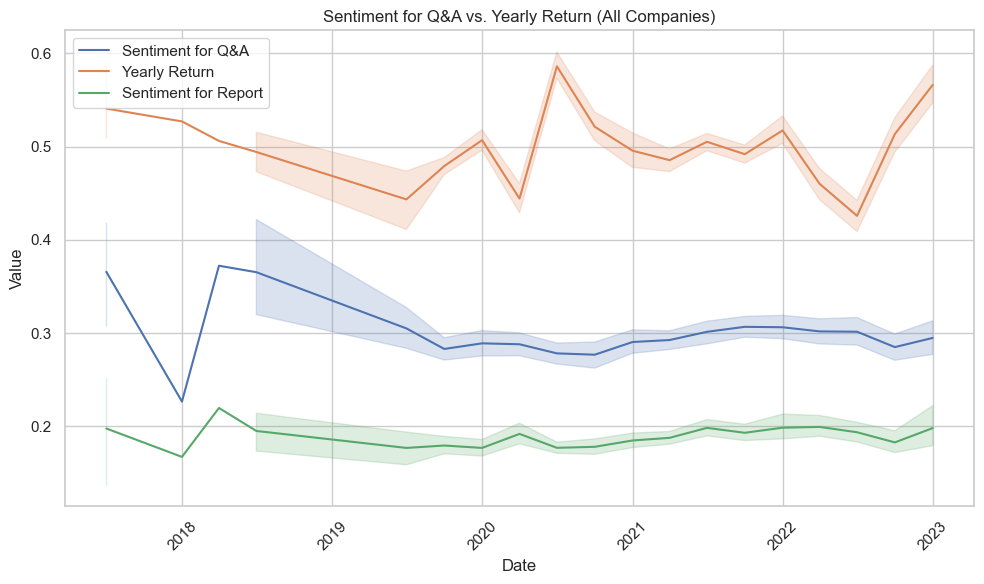

In [43]:

from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Assuming df is your DataFrame containing 'date', 'sentiment_QA', and 'yearly_return' columns

# Normalize sentiment_QA
# Min-Max Normalization
min_max_scaler = MinMaxScaler()
df_sorted['sentiment_QA_normalized'] = min_max_scaler.fit_transform(df_sorted[['sentiment_index_Q&A']])
df_sorted['sentiment_report_normalized'] = min_max_scaler.fit_transform(df_sorted[['sentiment_index_report']])

df_sorted['annual_yearly_normalized'] = min_max_scaler.fit_transform(df_sorted[['seas_1_1an']])
df_sorted['reversal_normalized'] = min_max_scaler.fit_transform(df_sorted[['ret_1_0']])
sns.set(style="whitegrid")
df_aapl = df_sorted[df_sorted['ticker'] == 'AAPL']
# Create the plot
plt.figure(figsize=(10, 6))
sns.lineplot(x='quarter_date', y='sentiment_QA_normalized', data=df_sorted, label='Sentiment for Q&A')
sns.lineplot(x='quarter_date', y='reversal_normalized', data=df_sorted, label='Yearly Return')
sns.lineplot(x='quarter_date', y='sentiment_report_normalized', data=df_sorted, label='Sentiment for Report')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Sentiment for Q&A vs. Yearly Return (All Companies)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

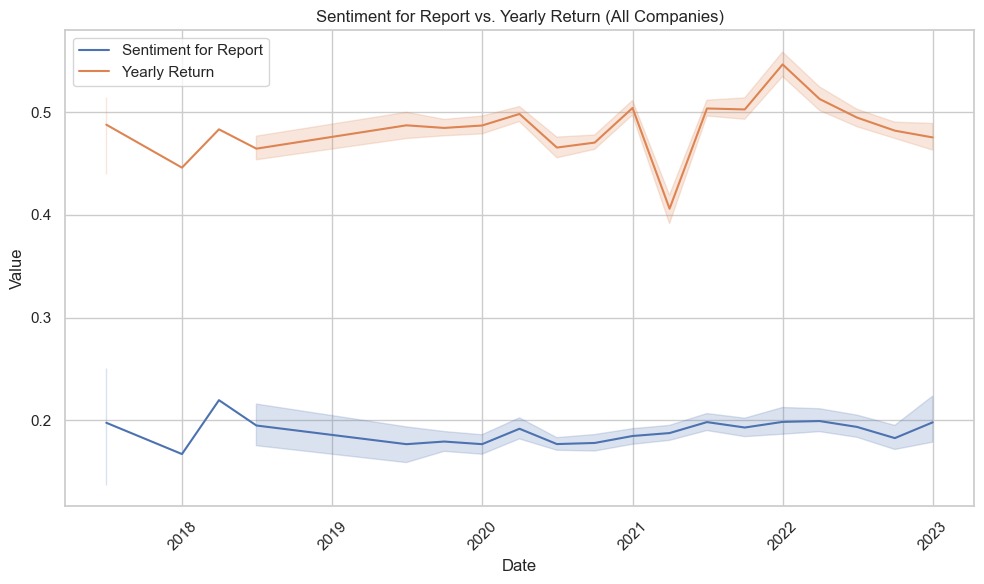

In [44]:
sns.set(style="whitegrid")
df_aapl = df_sorted[df_sorted['ticker'] == 'AAPL']
# Create the plot
plt.figure(figsize=(10, 6))
sns.lineplot(x='quarter_date', y='sentiment_report_normalized', data=df_sorted, label='Sentiment for Report')
sns.lineplot(x='quarter_date', y='annual_yearly_normalized', data=df_sorted, label='Yearly Return')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Sentiment for Report vs. Yearly Return (All Companies)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Trend between Q&A and Report

In [ ]:
def plot_sentiment_trend_report_vs_q_a(df, ticker):
    # Filter data for the specified ticker
    ticker_data = df[df['ticker'] == ticker]
    
    # Sort the DataFrame by adjusted_date
    ticker_data = ticker_data.sort_values(by='quarter_date')
    
    # Plot sentiment indexes against adjusted_date
    plt.figure(figsize=(10, 6))
    #plt.plot(ticker_data['quarter_date'], ticker_data['sentiment_index_Q&A'], marker='o', label='Q&A')
    #plt.plot(ticker_data['quarter_date'], ticker_data['sentiment_index_report'], marker='o', label='Report Sentiment')
    plt.plot(ticker_data['quarter_date'], ticker_data['sentiment_QA_normalized'], marker='o', label='Q&A')
    plt.plot(ticker_data['quarter_date'], ticker_data['sentiment_report_normalized'], marker='o', label='Report Sentiment')
    plt.title(f'Sentiment Analysis Trend of Investor Confidence for {ticker}')
    plt.xlabel('Date')
    plt.ylabel('Sentiment Index')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend()
    plt.show()




In [45]:
from sklearn.linear_model import Lasso
from tabulate import tabulate
from sklearn.metrics import mean_squared_error

df_sorted = df_sorted.dropna()

# Step 1: Separate features (controls) and target variable
X = df_sorted.drop(columns=['ret_1_0', 'ret_2_0','ret_3_0','ret_3_1','reversal_normalized', 'name', 'ticker', 'text', 'new_date', 'adjusted_date', 'quarter_date', 'transcript_id', 'sentiment1', 'sentiment2', 'text_blob_sentiment_index', 'VADER_sentiment_index','annual_yearly_normalized', 'yom', 'sentiment_index_Q&A', 'sentiment_index_report'])  # Features (controls)
y = df_sorted['reversal_normalized']  # Target variable

alphas = np.logspace(-4, 0, 100)

# Step 3: Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize an empty list to store coefficients for each alpha
coefficients = []
best_alpha = None
best_mse = float('inf')
best_model = None
best_coefficients = None

# Fit Lasso regression model for each alpha and select the best model based on MSE
for alpha in alphas:
    # Train Lasso regression model
    lasso_model = Lasso(alpha=alpha, random_state=42)
    lasso_model.fit(X_train, y_train)

    # Evaluate model's performance
    y_pred = lasso_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)

    # Check if current model has the lowest MSE
    if mse < best_mse:
        best_alpha = alpha
        best_mse = mse
        best_model = lasso_model
        best_coefficients = lasso_model.coef_

# Print the best alpha and corresponding MSE
print(f"Best Alpha: {best_alpha}")
print(f"Best Mean Squared Error: {best_mse}")

# Print the coefficients of the best model
print("Coefficients:")
for feature, coefficient in zip(X.columns, best_coefficients):
    print(f"{feature}: {coefficient}")
coefficients_table = [(feature, coefficient) for feature, coefficient in zip(X.columns, best_coefficients)]

# Generate LaTeX table
latex_table = tabulate(coefficients_table, headers=['Feature', 'Coefficient'], tablefmt='latex')

# Print LaTeX table
print(latex_table)

"""
# Fit Lasso regression model for each alpha and store coefficients
for alpha in alphas:
    # Step 4: Train Lasso regression model
    lasso_model = Lasso(alpha=alpha, random_state=42)  # Use alpha from loop
    lasso_model.fit(X_train, y_train)

    # Step 5: Evaluate model's performance
    y_pred = lasso_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    print(f"Mean Squared Error for alpha={alpha}: {mse}")

    # Step 6: Append coefficients to the list
    coefficients.append(lasso_model.coef_)

# Print the coefficients for each alpha
for alpha, coef in zip(alphas, coefficients):
    print(f"Alpha: {alpha}")
    for feature, coefficient in zip(X.columns, coef):
        print(f"{feature}: {coefficient}")
    print()
"""

c:\Users\egare\anaconda3\envs\new_era\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.394e-01, tolerance: 1.399e-03
  model = cd_fast.enet_coordinate_descent(
c:\Users\egare\anaconda3\envs\new_era\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.391e-01, tolerance: 1.399e-03
  model = cd_fast.enet_coordinate_descent(
c:\Users\egare\anaconda3\envs\new_era\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularis

Best Alpha: 1.0
Best Mean Squared Error: 0.008079970897065981
Coefficients:
seas_1_1an: -0.0
market_equity: -0.0
assets: -7.537480386967985e-09
sales: -4.6447586545038114e-08
book_equity: -1.2140544340171404e-07
net_income: -1.018837680927311e-06
enterprise_value: 1.3139602895157192e-07
at_gr1: 0.0
ca_gr1: 0.0
nca_gr1: -0.0
lt_gr1: 0.0
at_gr3: 0.0
cash_gr1a: 0.0
ca_gr3: 0.0
inv_gr1a: 0.0
nca_gr3: -0.0
rec_gr1a: 0.0
lt_gr3: 0.0
ppeg_gr1a: -0.0
market_equity.1: -7.48889306665139e-08
sentiment_QA_normalized: -0.0
sentiment_report_normalized: -0.0
\begin{tabular}{lr}
\hline
 Feature                     &   Coefficient \\
\hline
 seas\_1\_1an                  &  -0           \\
 market\_equity               &  -0           \\
 assets                      &  -7.53748e-09 \\
 sales                       &  -4.64476e-08 \\
 book\_equity                 &  -1.21405e-07 \\
 net\_income                  &  -1.01884e-06 \\
 enterprise\_value            &   1.31396e-07 \\
 at\_gr1                  

c:\Users\egare\anaconda3\envs\new_era\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.818e-01, tolerance: 1.399e-03
  model = cd_fast.enet_coordinate_descent(
c:\Users\egare\anaconda3\envs\new_era\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.818e-01, tolerance: 1.399e-03
  model = cd_fast.enet_coordinate_descent(
c:\Users\egare\anaconda3\envs\new_era\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularis

'\n# Fit Lasso regression model for each alpha and store coefficients\nfor alpha in alphas:\n    # Step 4: Train Lasso regression model\n    lasso_model = Lasso(alpha=alpha, random_state=42)  # Use alpha from loop\n    lasso_model.fit(X_train, y_train)\n\n    # Step 5: Evaluate model\'s performance\n    y_pred = lasso_model.predict(X_test)\n    mse = mean_squared_error(y_test, y_pred)\n    print(f"Mean Squared Error for alpha={alpha}: {mse}")\n\n    # Step 6: Append coefficients to the list\n    coefficients.append(lasso_model.coef_)\n\n# Print the coefficients for each alpha\nfor alpha, coef in zip(alphas, coefficients):\n    print(f"Alpha: {alpha}")\n    for feature, coefficient in zip(X.columns, coef):\n        print(f"{feature}: {coefficient}")\n    print()\n'

In [89]:
X

,seas_1_1an,market_equity,assets,sales,book_equity,net_income,enterprise_value,at_gr1,ca_gr1,nca_gr1,...,cash_gr1a,ca_gr3,inv_gr1a,nca_gr3,rec_gr1a,lt_gr3,ppeg_gr1a,market_equity.1,sentiment_QA_normalized,sentiment_report_normalized
3,-0.057214,9.184918e+05,406794.0,239176.0,140747.0,50525.0,9.637388e+05,0.228462,0.391728,0.154406,...,0.041055,0.724279,0.004201,0.473374,0.056348,0.923957,0.035278,9.184918e+05,0.399902,0.344631
4,-0.009418,8.055102e+05,373719.0,261376.0,117892.0,59431.0,8.338132e+05,-0.081307,-0.020736,-0.114429,...,0.024815,0.847676,0.001517,0.072909,-0.037242,0.550307,0.038574,8.055102e+05,0.490334,0.753168
5,0.200063,9.627661e+05,341998.0,258254.0,105860.0,57170.0,9.953041e+05,-0.069398,-0.051571,-0.079162,...,-0.022948,0.408188,-0.008123,0.004442,0.011316,0.350749,0.036649,9.627661e+05,0.150788,0.297101
6,-0.180709,1.105307e+06,322239.0,259034.0,96456.0,55695.0,1.118845e+06,-0.077200,0.165963,-0.197784,...,0.074200,0.439543,-0.008010,-0.116007,0.000332,0.260928,0.026738,1.105307e+06,0.372021,0.347211
7,0.044701,1.354255e+06,338516.0,260174.0,96688.0,55256.0,1.361722e+06,-0.074397,0.239685,-0.250395,...,0.101263,0.523538,0.000443,-0.182108,-0.009426,0.282216,0.016407,1.354255e+06,0.343759,0.295584
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3856,0.031924,1.050529e+05,14069.0,7422.0,4731.0,1909.0,1.087379e+05,0.076517,0.121400,0.034935,...,0.021679,0.662656,0.015495,0.608845,0.013221,0.467603,0.036747,1.050529e+05,0.149212,0.201130
3857,0.014429,9.139718e+04,13705.0,7626.0,4970.0,1982.0,9.487518e+04,-0.001457,-0.011100,0.007893,...,-0.027727,0.639352,0.018169,0.100266,0.010215,0.081885,0.032981,9.139718e+04,0.398197,0.207562
3858,0.054788,8.044461e+04,13900.0,7786.0,4863.0,2037.0,8.374361e+04,0.021383,0.048253,-0.004001,...,-0.008561,0.575358,0.021223,0.092819,0.008633,0.088920,0.023669,8.044461e+04,0.379852,0.184248
3859,-0.050939,7.327780e+04,13860.0,7900.0,4945.0,2073.0,7.687880e+04,0.004639,0.006329,0.002999,...,-0.033694,0.561315,0.025758,0.079797,0.006999,0.074247,0.028066,7.327780e+04,0.285680,0.182591


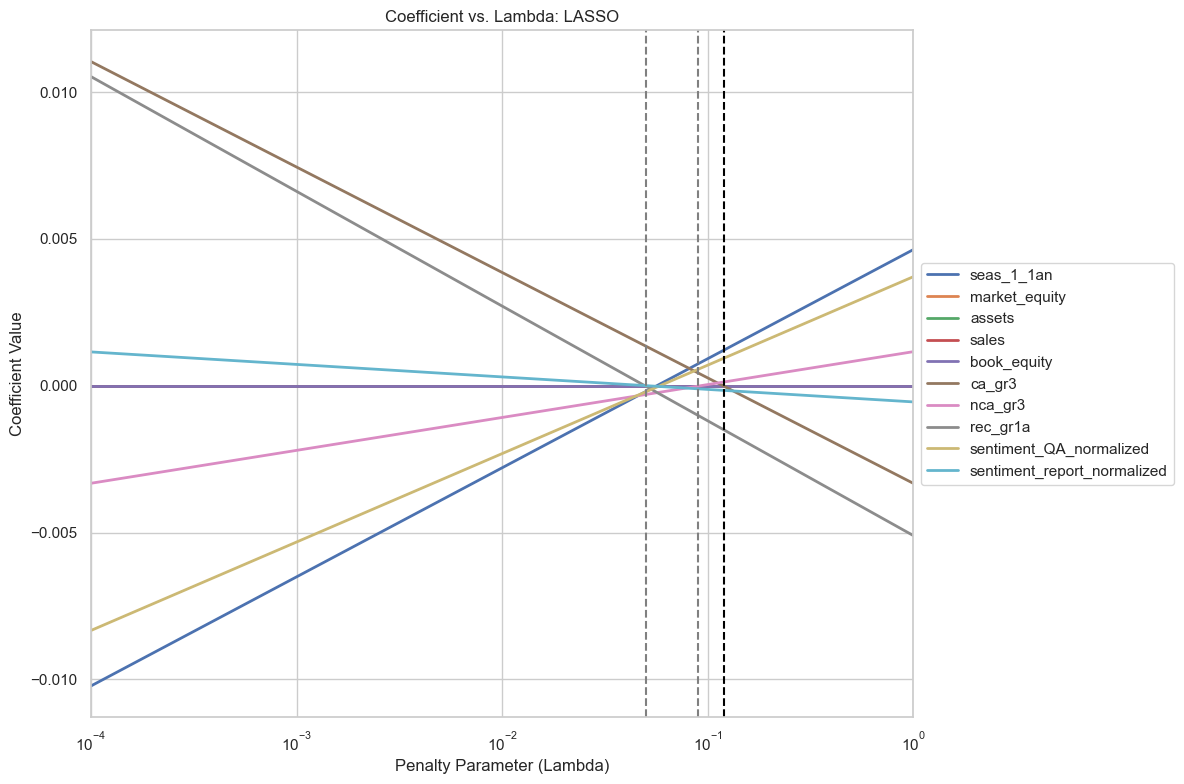

In [139]:
plt.figure(figsize=(12, 8))

features_of_interest = ['market_equity.1', 'nca_gr1', 'lt_gr1', 'at_gr3', 'ppeg_gr1a', 'inv_gr1a', 'lt_gr3', 'ca_gr1', 'cash_gr1a', 'at_gr1', 'enterprise_value', 'net_income']
# Plot the coefficients for each feature
for i, feature in enumerate(X.columns):
    if feature not in features_of_interest:
        # Fit a linear regression to the coefficients and alpha values
        coeffs = np.array(coefficients)[:, i]
        coef_approx = np.polyfit(np.log(alphas), coeffs, 1)
        
        # Plot the linear approximation
        plt.plot(alphas, np.polyval(coef_approx, np.log(alphas)), label=f'{feature}', linewidth=2)

plt.axvline(x=0.05, color='gray', linestyle='--', label='_nolegend_')  # Vertical dotted line
plt.axvline(x=0.09, color='gray', linestyle='--', label='_nolegend_')  # Vertical dotted line
plt.axvline(x=0.12, color='black', linestyle='--', label='_nolegend_')  # Vertical dotted line
plt.xscale('log')
plt.xlim(1e-4, 1)  # Set x-axis cutoff at 10^-1
plt.xlabel('Penalty Parameter (Lambda)')
plt.ylabel('Coefficient Value')
plt.title('Coefficient vs. Lambda: LASSO')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))  # Place 
plt.grid(True)
plt.tight_layout()
plt.show()


In [44]:
X

,ret_1_0,market_equity,ret_2_0,ret_3_0,ret_3_1,assets,sales,book_equity,net_income,enterprise_value,...,inv_gr1a,nca_gr3,rec_gr1a,lt_gr3,ppeg_gr1a,market_equity.1,sentiment_index_Q&A,sentiment_index_report,sentiment_QA_normalized,sentiment_report_normalized
3,0.135181,9.184918e+05,0.118131,0.053223,-0.072199,406794.0,239176.0,140747.0,50525.0,9.637388e+05,...,0.004201,0.473374,0.056348,0.923957,0.035278,9.184918e+05,0.180011,0.235353,0.433488,0.344631
4,-0.123735,8.055102e+05,-0.074283,0.015536,0.158937,373719.0,261376.0,117892.0,59431.0,8.338132e+05,...,0.001517,0.072909,-0.037242,0.550307,0.038574,8.055102e+05,0.202440,0.525000,0.518859,0.753168
5,0.076394,9.627661e+05,0.216885,0.066313,-0.009366,341998.0,258254.0,105860.0,57170.0,9.953041e+05,...,-0.008123,0.004442,0.011316,0.350749,0.036649,9.627661e+05,0.118226,0.201655,0.198317,0.297101
6,0.110684,1.105307e+06,0.191722,0.171975,0.055183,322239.0,259034.0,96456.0,55695.0,1.118845e+06,...,-0.008010,-0.116007,0.000332,0.260928,0.026738,1.105307e+06,0.173096,0.237182,0.407168,0.347211
7,0.054010,1.354255e+06,0.158129,0.247796,0.183856,338516.0,260174.0,96688.0,55256.0,1.361722e+06,...,0.000443,-0.182108,-0.009426,0.282216,0.016407,1.354255e+06,0.166086,0.200580,0.380488,0.295584
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3856,0.027012,1.050529e+05,0.145033,0.086707,0.058125,14069.0,7422.0,4731.0,1909.0,1.087379e+05,...,0.015495,0.608845,0.013221,0.467603,0.036747,1.050529e+05,0.117835,0.133613,0.196829,0.201130
3857,-0.030732,9.139718e+04,-0.205159,-0.126441,-0.098743,13705.0,7626.0,4970.0,1982.0,9.487518e+04,...,0.018169,0.100266,0.010215,0.081885,0.032981,9.139718e+04,0.179588,0.138174,0.431879,0.207562
3858,-0.035656,8.044461e+04,-0.091980,-0.115707,-0.083011,13900.0,7786.0,4863.0,2037.0,8.374361e+04,...,0.021223,0.092819,0.008633,0.088920,0.023669,8.044461e+04,0.175038,0.121644,0.414561,0.184248
3859,-0.142536,7.327780e+04,-0.087738,-0.082615,0.069882,13860.0,7900.0,4945.0,2073.0,7.687880e+04,...,0.025758,0.079797,0.006999,0.074247,0.028066,7.327780e+04,0.151682,0.120469,0.325660,0.182591


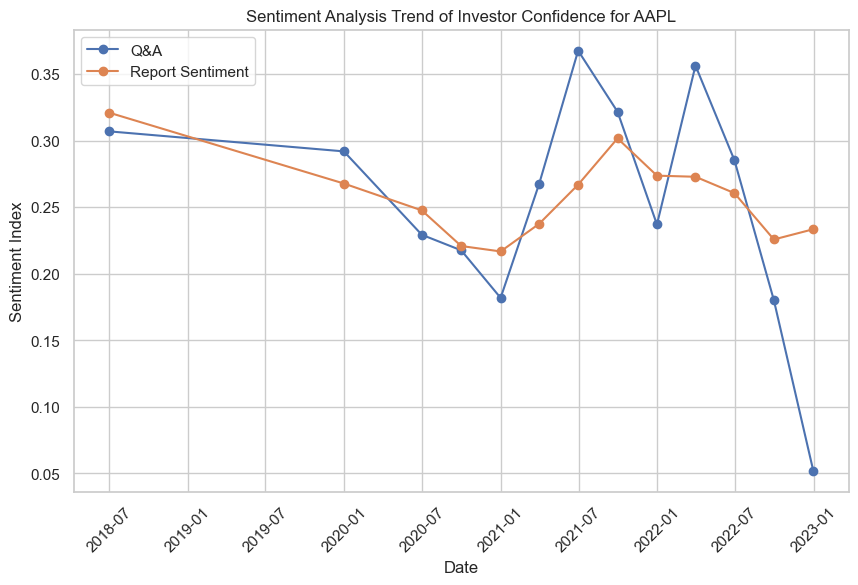

In [55]:
plot_sentiment_trend_report_vs_q_a(df_sorted, 'AAPL')

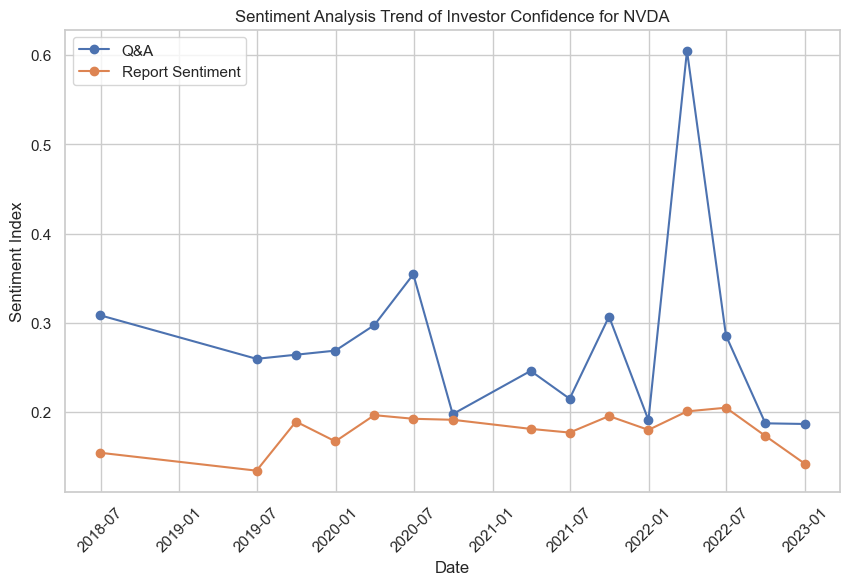

In [56]:
plot_sentiment_trend_report_vs_q_a(df_sorted, 'NVDA')

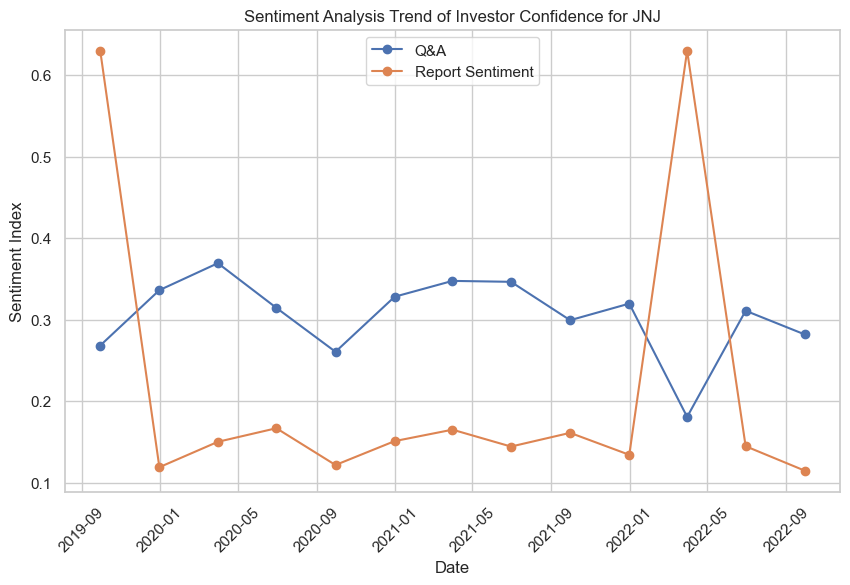

In [57]:
plot_sentiment_trend_report_vs_q_a(df_sorted, 'JNJ')

SENTIMENT VS RETURN

In [59]:
def plot_sentiment_trend_yearly_return(df, ticker):
    # Filter data for the specified ticker
    ticker_data = df[df['ticker'] == ticker]
    
    # Sort the DataFrame by adjusted_date
    ticker_data = ticker_data.sort_values(by='quarter_date')
    
    # Plot sentiment indexes against adjusted_date
    plt.figure(figsize=(10, 6))
    plt.plot(ticker_data['quarter_date'], ticker_data['sentiment_QA_normalized'], label='Q&A')
    plt.plot(ticker_data['quarter_date'], ticker_data['reversal_normalized'],  label='Short-term Returns')
    plt.title(f'Sentiment Analysis Trend vs. Mean Reversal for {ticker}')
    plt.xlabel('Date')
    plt.ylabel('Sentiment Index')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend()
    plt.show()


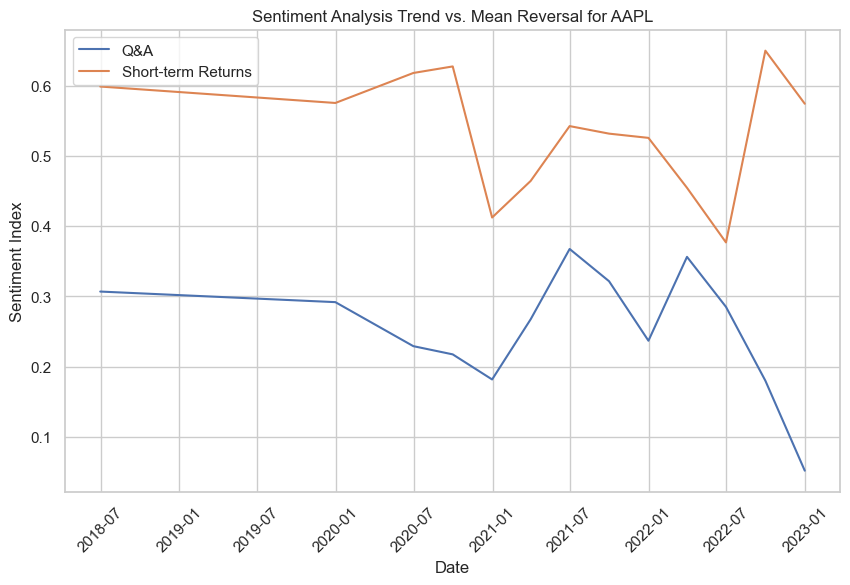

In [60]:
plot_sentiment_trend_yearly_return(df_sorted, 'AAPL')

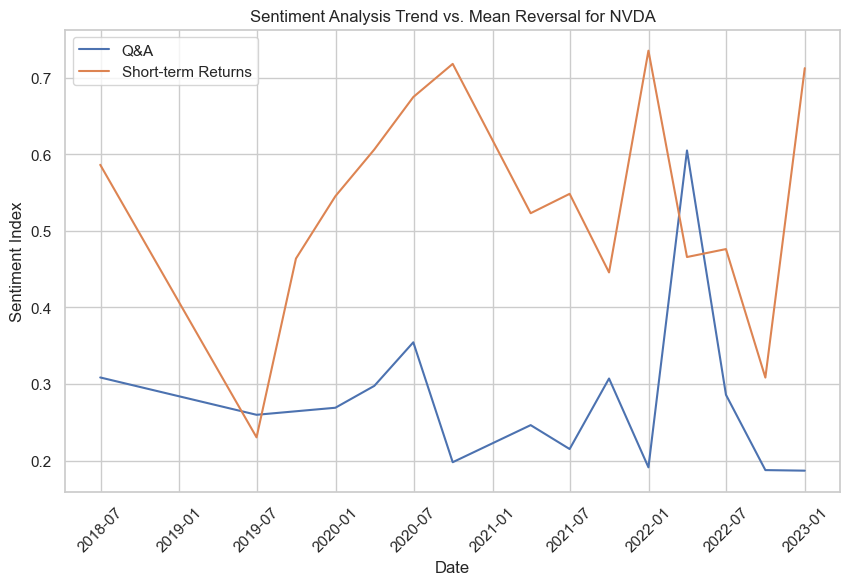

In [61]:
plot_sentiment_trend_yearly_return(df_sorted, 'NVDA')

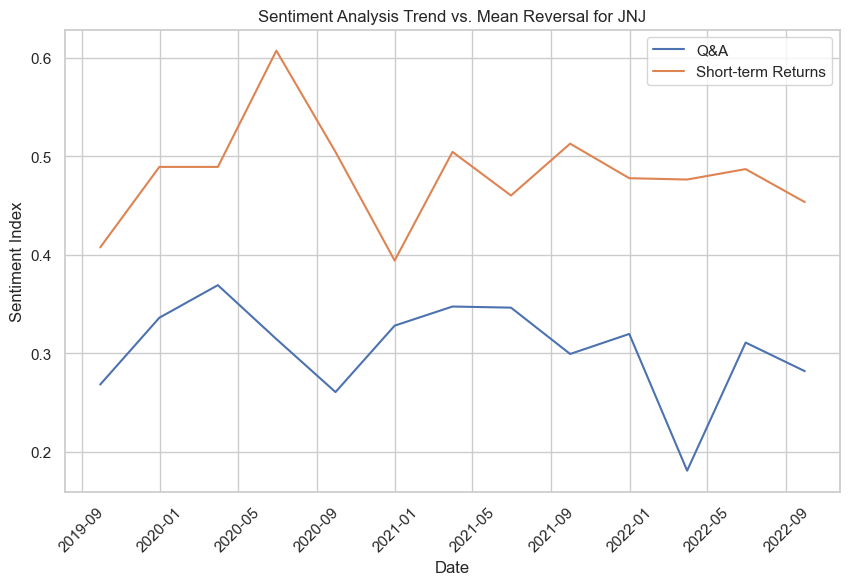

In [62]:
plot_sentiment_trend_yearly_return(df_sorted, 'JNJ')

In [144]:
from tabulate import tabulate

# Assuming 'df' is your DataFrame and 'column_names' is a list of column names
column_names = ['sentiment_index_Q&A', 'sentiment_index_report', 'ca_gr3', 'ret_1_0', 'market_equity', 'assets', 'sales', 'at_gr1', 'enterprise_value']  # Add your column names here
statistics = []

# Iterate over the columns and calculate statistics
for col in column_names:
    column_data = df_sorted[col]
    mean = column_data.mean()
    minimum = column_data.min()
    maximum = column_data.max()
    std_dev = column_data.std()
    
    statistics.append([col, mean, minimum, maximum, std_dev])

# Create LaTeX table
latex_table = tabulate(statistics, headers=['Column', 'Mean', 'Min', 'Max', 'Std Dev'], tablefmt='latex')

print(latex_table)


\begin{tabular}{lrrrr}
\hline
 Column                 &           Mean &           Min &              Max &        Std Dev \\
\hline
 sentiment\_index\_Q\&A    &      0.17022   &    0.0808277  &      0.328846    &      0.0311332 \\
 sentiment\_index\_report &      0.152766  &   -0.00898505 &      0.7         &      0.0729085 \\
 ca\_gr3                 &      0.399023  &   -0.735796   &      6.43536     &      0.66734   \\
 ret\_1\_0                &      0.0309825 &   -0.491818   &      0.55516     &      0.102068  \\
 market\_equity          & 146294         & 3657.54       &      2.85231e+06 & 275075         \\
 assets                 &  86751.7       & 1465.61       &      1.58944e+06 & 118816         \\
 sales                  &  48054.5       &  480.735      & 485902           &  66122.1       \\
 at\_gr1                 &      0.13839   &   -0.469435   &      5.6602      &      0.320192  \\
 enterprise\_value       & 164174         & 4178.29       &      2.92619e+06 & 283260    

In [147]:
correlation_matrix = df_sorted[column_names].corr()

# Print or display the correlation matrix
correlation_matrix_latex = tabulate(correlation_matrix, tablefmt='latex', headers='keys')

# Print or display the LaTeX table
print(correlation_matrix_latex)

\begin{tabular}{lrrrrrrrrr}
\hline
                        &   sentiment\_index\_Q\&A &   sentiment\_index\_report &     ca\_gr3 &    ret\_1\_0 &   market\_equity &     assets &      sales &      at\_gr1 &   enterprise\_value \\
\hline
 sentiment\_index\_Q\&A    &             1         &                0.134075  &  0.0718947 & -0.0232542 &      0.0587431  &  0.0430826 &  0.0288971 &  0.04937    &         0.0641438  \\
 sentiment\_index\_report &             0.134075  &                1         &  0.0488114 &  0.0140949 &      0.033384   &  0.0149994 &  0.0430029 &  0.0294647  &         0.0406158  \\
 ca\_gr3                 &             0.0718947 &                0.0488114 &  1         &  0.0813074 &      0.0301757  & -0.093801  & -0.0470473 &  0.430133   &         0.0164926  \\
 ret\_1\_0                &            -0.0232542 &                0.0140949 &  0.0813074 &  1         &      0.0315839  & -0.0227027 & -0.0238187 &  0.026601   &         0.0317229  \\
 market\_equity         